# архитектура сети

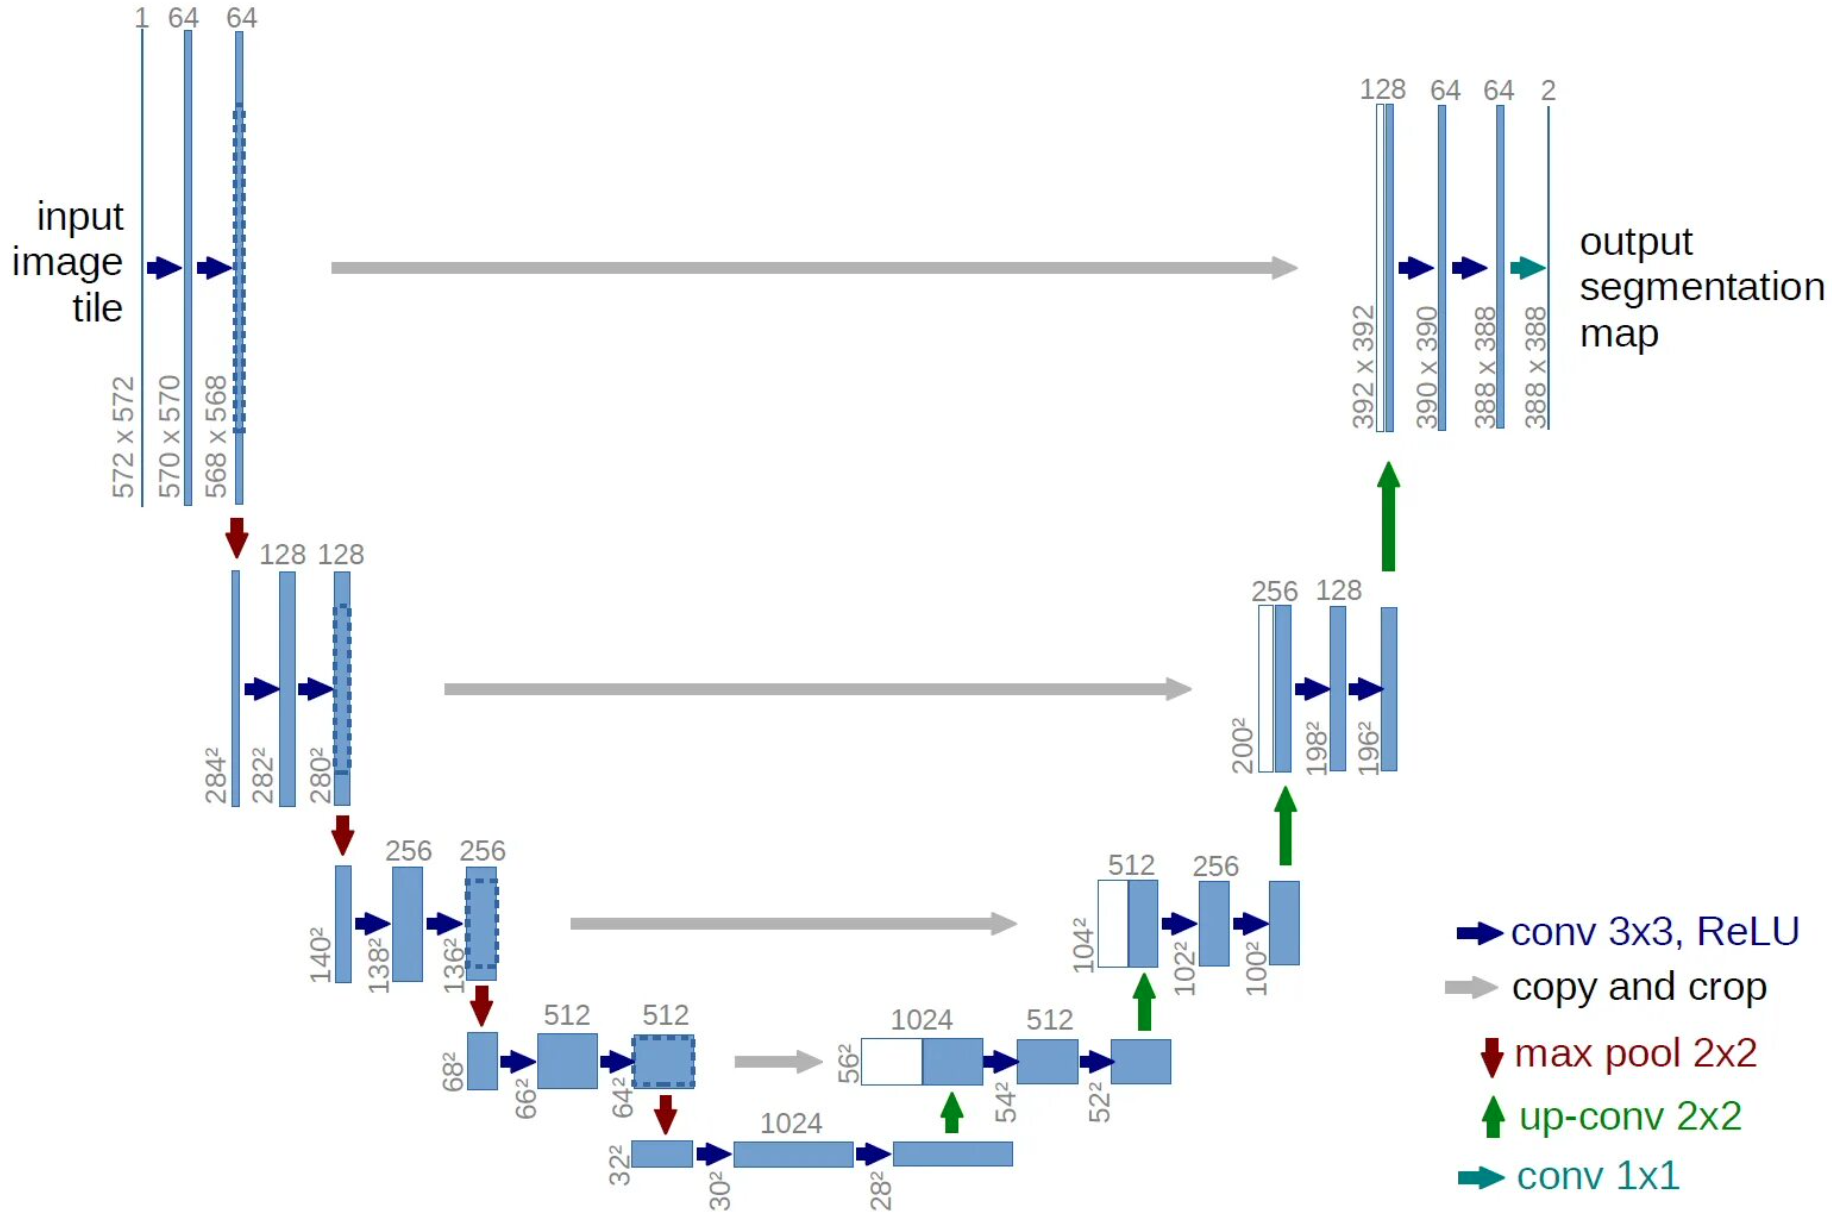

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

дополнительные функции

In [2]:
def size_tensor(image ,new_height , new_width):
    '''! изменения размера изображения (или тензора) на новую высоту и ширину, используя интерполяцию.
    в данном случае используется билинейная интерполяцию,
    что позволяет сгладить значения пикселей в соответствии с новыми размерами.,

    :param image: изображение,
    :param new_height: новая высота,
    :param new_width: новая ширина,
    :return scaled_image: изображение с новой высотой и шириной'''
    scaled_image = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=True)
    return scaled_image

In [3]:
def double_conv(in_ch, out_ch):
    '''! функция, двухкратной свертки 3x3, где
    :param in_ch: кол-во входных признаков,
    :param out_ch: кол-во выходных признаков,
    :return conv: результат свертки'''
    conv = nn.Sequential(   #определяем последовательность слоев

        nn.BatchNorm2d(in_ch),  #нормализация данных
        nn.Conv2d(in_ch, out_ch, kernel_size=3), #Сверточный слой с ядром размером 3x3
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True), # Функция активации ReLU, inplace=True - без использовании доп памяти

        nn.Conv2d(out_ch, out_ch, kernel_size=3),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )

In [4]:
def crop_image(target_img, img):
    '''! функция обрезки изображения (тензора), где
    :param target_img: желаемое изображение (тензор),
    :param img: текущее изображение (тензор),
    :return tensor: искомый тензор'''
    target_size = target_img.size()[2] #определим размер желаемого избр, [2] предполагает [batch_size, channels, height, width].
    tensor_size = img.size()[2]  #размер желаемого избр
    delta = tensor_size - target_size # определим сколько пикселей следует обрезать с каждой стороны текущего изображения.
    delta = delta // 2 #чтобы с обеих сторон изображения было обрезано одинаковое количество пикселей.
    return img[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

In [5]:
def output_layer(in_ch, out_ch):
    '''! функция, отвечающая за выходной слой, где
    :param in_ch: кол-во входных признаков,
    :param out_ch: кол-во выходных признаков,
    :return conv_layer: выходной слой'''
    conv_layer = nn.Sequential(
        nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=1), #Сверточный слой с ядром размером 1x1. входных признаков и преобразует их в выходные признаки.
        nn.BatchNorm2d(out_ch),
        #nn.Sigmoid() #f активации
    )
    return conv_layer

In [6]:
def pad_image_to_square(img, num):
    '''! функция добавление пустых пикселей по краям,
    чтобы сделать изображение квадратным, где
    :param img: изображение,
    :param num: желаемая длина одной стороны фотографии,
    :return padded_img: дополненное до нужного размера изображение'''

    channels, height, width = img.size()
    diff = abs(num - width) #разница между желаемой шириной квадратного изображения (num) и текущей шириной изображения (width
    # определение кол-ва пикселей для добавления с каждой стороны
    padding = diff // 2

    # дополнение до желаемого размера нулями в ширину
    img = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)
    print(img.shape)

    channels, height, width = img.size()
    diff = abs(height-width)
    #Определение кол-ва пикселей для добавления
    padding = diff // 2


    # Дополнение тензора
    if height < width:
        padded_img = torch.nn.functional.pad(img, (0, 0, padding, diff - padding), mode='constant', value=0)
    else:
        padded_img = torch.nn.functional.pad(img, (padding, diff - padding, 0, 0), mode='constant', value=0)


    return padded_img


 реализация архитектуры U-Net

In [7]:
class Unet(nn.Module):

    def __init__(self):
        super(Unet, self).__init__()

        self.maxpool2d = nn.MaxPool2d(kernel_size=2, stride=2) #инициализация слоя максимальной пулинга (подвыборки), который будет использоваться для уменьшения размера изображения в кодировщике.

        #encoder (двойная свертка заранее)
        self.down_conv1 = double_conv(1, 64)
        self.down_conv2 = double_conv(64, 128)
        self.down_conv3 = double_conv(128, 256)
        self.down_conv4 = double_conv(256, 512)
        self.down_conv5 = double_conv(512, 1024)

        #trans - transpose

        #decoder
        self.conv_bn = nn.BatchNorm2d(1024)

        self.up_trans1 = nn.ConvTranspose2d(  # слой транспонированной свертки с ядром 2*2
            in_channels=1024, out_channels=512,  #28*28 -> 56*56
            kernel_size=2, stride=2
            )

        self.up_conv1 = double_conv(1024, 512)  #1024 -> 512 -> 512


        self.up_trans2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,    #52*52-> 104*104
            kernel_size=2, stride=2
            )
        self.up_conv2 = double_conv(512, 256) #512->256 ->256


        self.up_trans3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,   #100*100 - >200*200
            kernel_size=2, stride=2
            )
        self.up_conv3 = double_conv(256, 128)


        self.up_trans4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,  #196*196 - > 392*392
            kernel_size=2, stride=2
            )
        self.up_conv4 = double_conv(128, 64)

        #выходной слой
        self.out = output_layer(64, 1)

    def forward(self, image):
        # Forward pass encoder
        down1 = self.down_conv1(image) #1-> 64 -> 64
        down2 = self.maxpool2d(down1)  #max pool 2*2
        down3 = self.down_conv2(down2) #64 -> 128 -> 128
        down4 = self.maxpool2d(down3)
        down5 = self.down_conv3(down4) #128 -> 256 -> 256
        down6 = self.maxpool2d(down5)
        down7 = self.down_conv4(down6) #256 -> 512 -> 512
        down8 = self.maxpool2d(down7)
        down9 = self.down_conv5(down8) #512 -> 1024 -> 1024

        # Forward pass decoder
        x_norm = self.conv_bn(down9)

        x = self.up_trans1(x_norm)
        y = crop_image(x, down7) #обрезка до 512
        x = self.up_conv1(torch.cat([x,y], 1)) #соединение

        x = self.up_trans2(x)
        y = crop_image(x, down5)
        x = self.up_conv2(torch.cat([x,y], 1))

        x = self.up_trans3(x)
        y = crop_image(x, down3)
        x = self.up_conv3(torch.cat([x,y], 1))

        x = self.up_trans4(x)
        y = crop_image(x, down1)
        x = self.up_conv4(torch.cat([x,y], 1))

        return self.out(x)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#batch_size = 4
learning_rate = 0.001
num_epochs = 10

In [9]:
# определение используемой архитектуры
model = Unet()
if torch.cuda.is_available():
    model.cuda()



# функция потерь и оптимизатор
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

valid_loss , train_loss = [] , []

запуск обучения

In [10]:
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        # Прямое распространение ошибки
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Обратное распространение ошибки
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        model.eval()
        val_loss = 0
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets)
        val_loss /= len(val_dataloader)
    valid_loss.append(val_loss.item())
    train_loss.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}  , Val Loss: {val_loss.item():.4f}")


NameError: ignored